# Proyecto Ciencia de Datos 2 – Ventas (UY)

**Enriquecimiento con datos públicos (INE/CKAN + SNIG)**  


> **Propósito ejecutivo:** identificar **dónde** vendemos mejor/peor y **por qué**, usando contexto público de Uruguay.  


## Abstracto (motivación y audiencia)
- **Qué buscamos:** explicar diferencias de ventas entre **departamentos** de Uruguay.
- **Cómo lo hacemos:** enriquecemos el dataset de ventas con **Población** (INE/CKAN) y una **proxy de actividad económica** (**Empresas** por departamento, archivo público). Creamos:
  - `intensidad_mercado` = ventas per cápita
  - `nivel_desarrollo_regional` = promedio de *z-scores* de Población y Empresas
- **Para quién:** Gerencia de Ventas, a fin de tomar decisiones de **cobertura, promociones y expansión**.


## Resumen de metadata (qué datos usamos)
- **Ventas (CSV del proyecto):** registros transaccionales con Departamento y valor de venta.
- **Población por Departamento (INE/CKAN, CSV).**
- **Empresas por Departamento (Excel público; se agrupa para obtener conteo).**
- **Geometría de Departamentos (SNIG ArcGIS, GeoJSON)** para visualizar mapa.
En las celdas siguientes se imprimen **filas/columnas** y **tipos** principales.


## 1) Instalar dependencias (ejecutar una vez por sesión en Colab)

In [1]:
!pip install -q pandas numpy requests geopandas pyproj shapely mapclassify matplotlib openpyxl scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 26.9 MB/s eta 0:00:00


## 2) Importar librerías

In [2]:
import pandas as pd
import numpy as np
import requests, io, json
import matplotlib.pyplot as plt

import geopandas as gpd
import mapclassify as mc

plt.rcParams['figure.figsize']=(7,5)
plt.rcParams['axes.grid']=True


## 3) Preguntas / Hipótesis
1. ¿Qué departamentos muestran **mayor intensidad de mercado** (ventas per cápita)?  
2. ¿Existe relación entre **Empresas** (proxy de actividad económica) y **Ventas**?  
3. ¿Cómo cambia el desempeño por región al considerar un **nivel de desarrollo regional** (población + empresas)?


## 4) Fuentes públicas (APIs/descargas)

In [3]:
ventas_url = "https://raw.githubusercontent.com/Gonrampsn4/Proyecto-Ciencia-de-Datos2-Ventas_Ramallo/main/dataset_ventas_3000.csv"
poblacion_url = "https://catalogodatos.gub.uy/dataset/7e7c97c8-a7cc-4f1f-9c85-a2c25ae28141/resource/5e1cf37b-201e-43b7-a5ba-66ee0e64e4d0/download/datosbasicosjds.csv"
empresas_xlsx_url = "https://catalogodatos.gub.uy/dataset/575ccb87-ae74-4dcd-ba4b-cf050bd8e08a/resource/e8e6f2e4-357e-4027-b91a-407b5d5501f7/download/empresasdei_20230330.xlsx"
departamentos_geojson_url = "https://web.snig.gub.uy/arcgisserver/rest/services/Uruguay/SNIG_Catastro/MapServer/2/query?where=1%3D1&outFields=Nombre&outSR=4326&f=geojson"

ventas     = pd.read_csv(ventas_url)
poblacion  = pd.read_csv(poblacion_url)
emp_resp   = requests.get(empresas_xlsx_url); emp_resp.raise_for_status()
empresas   = pd.read_excel(io.BytesIO(emp_resp.content))
geojson    = requests.get(departamentos_geojson_url).json()
gdf_deptos = gpd.GeoDataFrame.from_features(geojson['features'], crs='EPSG:4326').rename(columns={'Nombre':'Departamento'})

print("Ventas:", ventas.shape); display(ventas.head(3))
print("Población:", poblacion.shape); display(poblacion.head(3))
print("Empresas:", empresas.shape); display(empresas.head(3))
print("Geometría:", gdf_deptos.shape); gdf_deptos.head(3)


Ventas: (3000, 18)


,ID,Fecha_Venta,Departamento,Ciudad,Categoría,Subcategoría,Nombre_Producto,Precio,Cantidad,Total_Venta,Tipo_Venta,Estado_Producto,Método_Pago,Cliente,Email_Cliente,Teléfono,Entrega,Opinión
0,4b9891d4-21de-4156-849e-6a8133c4634b,10/3/2025,Montevideo,Paso de Carrasco,Juguetes,Figuras de acción,Superman,86732.23,5.0,433661.15,Particular,Usado,Efectivo,Angélica Río-Capdevila,brudafne@yahoo.com,+34987 895 476,Retiro en local,Mala
1,d4a5e1f5-0ee2-423c-9571-28a9b6cf7d60,5/1/2025,Canelones,Atlántida,Libros,Novelas,Cien años de soledad,71464.53,6.0,428787.18,Particular,Usado,Tarjeta,Florentina Quiroga Adadia,gibertaurea@hotmail.com,+34 737825415,Retiro en local,Mala
2,14ef7cd7-4401-44ff-bdfd-2513c74b5789,18/5/2025,Colonia,Colonia del Sacramento,Hogar,Electrodomésticos,Aspiradora Robot,58823.08,8.0,470584.64,Particular,Nuevo,Tarjeta,Roxana Pascual Riba,camarabelen@gmail.com,+34 601643491,Retiro en local,Regular


Población: (19, 55)


,Junta Departamental,Tiene WEB,Link de la web,Dirección,Teléfono 1,Telefono 2,Email,Plenarios,Hora Plenario,Local propio,...,Por que medios,Legislatura,Período,Presidente,Vice-Presidente,Segundo Vice-Presidente,Secretario General,Abogados,¿Cuantos?,Escala de salario de funcionarios LINK
0,Artigas,NO,NaN,Cnel. Carlos Lecueder 510,4772 4833,NaN,juntadeartigas@gmail.com,1er - 2do y 3er jueves de cada mes,20.30,Si,...,NaN,2015-2020,2017-2018,Rosana Caraballo,Federico Ferreira,Francisco Bandera,Puesto VACANTE,Si,1,NaN
1,Canelones,Si,http://www.juntadecanelones.gub.uy/canelones/,Luis Alberto de Herrera,4332 2420,NaN,juntacan@juntadecanelones.gub.uy,1er y 3er viernes de cada mes,18.00,Si,...,NaN,2015-2020,2017-2018,Eduardo Molinari,Sergio Cáceres,NaN,Agustin Mazzini,Si,3,http://www.juntadecanelones.gub.uy/canelones/P...
2,Cerro Largo,Si,http://www.juntacerrolargo.gub.uy/,José Pedro Varela 725,4642 2283,4642 3471,presidencia@juntacerrolargo.gub.uy,Jueves - cada 15 días,19.00,Si,...,NaN,2015-2020,2017-2018,Ignacio Ubilla,Washington Larrosa,NaN,Sr. Nery De Moura,Si,1,NaN


Empresas: (5249, 31)


,Estado de la empresa,RUT,Denominacion Social,Nombre comercial,Tamaño de la empresa,Tipos de actividad de la empresa,Descripcion de la Actividad,Codigo CIIU principal,Descripcion Codigo CIIU principal,Codigos CIIU secundarios,...,Departamento (EP),Codigo Postal (EP),Longitud (EP),Latitud (EP),Email publico,Sitio web,Tipo de telefono,Numero de telefono,Fecha de Registro,Fecha de vencimiento
0,Aprobado,217231960015,ANFANG S. R. L.,CULTO,Micro Empresa,Industrial;Comercial,Importación tostado empaquetado y comercializa...,10799,Elaboración de otros productos alimenticios n....,NaN,...,MONTEVIDEO,11000,'-55.06622314453125,'-31.822731385097477,admin@cultocafe.uy,S/D,Comercial,094974477,2024-10-09,2025-10-09
1,Aprobado,218871790012,ATOM BUILDERS S.A.S.,ATOM BUILDERS S.A.S,Micro Empresa,Comercial;Servicios,Desarrollo de software,62010,Actividades de programación informática,NaN,...,MONTEVIDEO,11000,'-56.205705482761374,'-34.90659436543681,osvaldo@fierastudio.com,S/D,Fijo,29151252,2024-01-25,2025-01-25
2,Aprobado,20588440013,FRANCO POSSAMAY SAS,S/D,Micro Empresa,Comercial,Actividades de programación informática,62010,Actividades de programación informática,NaN,...,CANELONES,S/D,'-55.865478515625,'-33.15594830078648,escritorio@barindelli.com.uy,S/D,Movil,099302210,2024-10-07,2025-10-07


Geometría: (19, 2)


,geometry,Departamento
0,"POLYGON ((-57.67574 -30.77996, -57.67606 -30.7...",SALTO
1,"POLYGON ((-57.15538 -33.11598, -57.15754 -33.1...",SORIANO
2,"POLYGON ((-57.15538 -33.11598, -57.15488 -33.1...",FLORES


### 4.1) Metadata rápida

In [4]:
def quick_info(df, name):
    print(f"\n{name}: {df.shape[0]} filas × {df.shape[1]} columnas")
    display(df.dtypes.to_frame('dtype').head(12))

quick_info(ventas, "Ventas")
quick_info(poblacion, "Población")
quick_info(empresas, "Empresas")



Ventas: 3000 filas × 18 columnas


,dtype
ID,object
Fecha_Venta,object
Departamento,object
Ciudad,object
Categoría,object
Subcategoría,object
Nombre_Producto,object
Precio,float64
Cantidad,float64
Total_Venta,float64



Población: 19 filas × 55 columnas


,dtype
Junta Departamental,object
Tiene WEB,object
Link de la web,object
Dirección,object
Teléfono 1,object
Telefono 2,object
Email,object
Plenarios,object
Hora Plenario,object
Local propio,object



Empresas: 5249 filas × 31 columnas


,dtype
Estado de la empresa,object
RUT,int64
Denominacion Social,object
Nombre comercial,object
Tamaño de la empresa,object
Tipos de actividad de la empresa,object
Descripcion de la Actividad,object
Codigo CIIU principal,object
Descripcion Codigo CIIU principal,object
Codigos CIIU secundarios,object


## 5) Limpieza y estandarización por Departamento

In [5]:
def norm_depto(s):
    if pd.isna(s): return s
    s = str(s).strip().upper()
    repl = {
        "SAN JOSÉ": "SAN JOSÉ","SAN JOSE":"SAN JOSÉ",
        "RIO NEGRO":"RÍO NEGRO","RÍO NEGRO":"RÍO NEGRO",
        "PAYSANDU":"PAYSANDÚ","PAYSANDÚ":"PAYSANDÚ",
        "TACUAREMBO":"TACUAREMBÓ","TACUAREMBÓ":"TACUAREMBÓ",
    }
    return repl.get(s, s)

dept_cols = [c for c in ventas.columns if c.lower() in ["departamento","depto","region","provincia","estado"]]
if not dept_cols:
    raise ValueError("No se encontró columna de departamento en ventas. Cree/renombre 'Departamento'.")
ventas["Departamento"] = ventas[dept_cols[0]].apply(norm_depto)

pop_dept_cols = [c for c in poblacion.columns if "depar" in c.lower() or c.lower()=="departamento"]
if not pop_dept_cols: raise ValueError("Población: falta columna de 'Departamento'.")
poblacion["Departamento"] = poblacion[pop_dept_cols[0]].apply(norm_depto)

cand_pop = [c for c in poblacion.columns if "poblac" in c.lower() or "habit" in c.lower()]
if not cand_pop:
    print("Columnas disponibles:", list(poblacion.columns))
    raise ValueError("Indique manualmente la columna de población.")
poblacion = poblacion[["Departamento", cand_pop[0]]].rename(columns={cand_pop[0]:"Poblacion"})

emp_dept_cols = [c for c in empresas.columns if "depar" in c.lower() or c.lower()=="departamento"]
if not emp_dept_cols:
    print("Columnas Excel 'empresas':", list(empresas.columns))
    raise ValueError("Empresas: falta 'Departamento'.")
empresas["Departamento"] = empresas[emp_dept_cols[0]].apply(norm_depto)
empresas_por_depto = empresas.groupby("Departamento", as_index=False).size().rename(columns={"size":"Empresas"})

contexto_depto = (poblacion.merge(empresas_por_depto, on="Departamento", how="left"))
contexto_depto["Empresas"] = pd.to_numeric(contexto_depto["Empresas"], errors="coerce").fillna(0).astype(int)
contexto_depto.head()


,Departamento,Poblacion,Empresas
0,ARTIGAS,73.377,15
1,CANELONES,520.173,259
2,CERRO LARGO,84.698,16
3,COLONIA,123203,71
4,DURAZNO,57084,11


## 6) Agregación de ventas y nuevas métricas

In [6]:
import re
from scipy.stats import zscore

for c in ventas.columns:
    if any(k in c.lower() for k in ["fecha","date","dia"]):
        ventas[c] = pd.to_datetime(ventas[c], errors="coerce")

def to_numeric_safe_col(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip()
    s = (s.str.replace("UYU","",regex=False)
           .str.replace("USD","",regex=False)
           .str.replace("$","",regex=False)
           .str.strip())
    s = s.str.replace(".","",regex=False)
    s = s.str.replace(",",".",regex=False)
    s = s.str.replace(r"[^0-9\.-]","",regex=True)
    return pd.to_numeric(s, errors="coerce")

keywords_valor = ["monto","importe","total","precio","price","amount"]
candidatas = [c for c in ventas.columns if any(k in c.lower() for k in keywords_valor)]

candidatas_info = []
for c in candidatas:
    num_col = to_numeric_safe_col(ventas[c])
    notnulls = num_col.notna().sum()
    candidatas_info.append((c, notnulls, num_col))

if candidatas_info:
    candidatas_info.sort(key=lambda x: x[1], reverse=True)
    monto_col, _, monto_num = candidatas_info[0]
else:
    posibles = []
    for c in ventas.columns:
        if not any(k in c.lower() for k in ["id","codigo","cod","nro","numero"]):
            num_col = to_numeric_safe_col(ventas[c])
            if num_col.notna().sum() > 0:
                posibles.append((c, num_col.notna().sum(), num_col))
    if not posibles: raise ValueError("No se encontró columna usable como valor de venta.")
    posibles.sort(key=lambda x: x[1], reverse=True)
    monto_col, _, monto_num = posibles[0]

print("Usando columna de valor de venta:", monto_col)
ventas[monto_col] = monto_num.fillna(0)

ventas_depto = (ventas
    .groupby("Departamento", as_index=False)
    .agg(ventas_total=(monto_col,"sum"),
         operaciones=("Departamento","size"))
)
ventas_depto["ticket_promedio"] = ventas_depto["ventas_total"]/ventas_depto["operaciones"].replace(0, pd.NA)

contexto_depto["Poblacion"] = pd.to_numeric(contexto_depto["Poblacion"], errors="coerce")
panel = ventas_depto.merge(contexto_depto, on="Departamento", how="left")
panel["Poblacion"] = panel["Poblacion"].replace(0, pd.NA)
panel["intensidad_mercado"] = panel["ventas_total"] / panel["Poblacion"]

panel["z_pop"] = zscore(panel["Poblacion"].fillna(panel["Poblacion"].median()))
panel["z_emp"] = zscore(panel["Empresas"].fillna(panel["Empresas"].median()))
panel["nivel_desarrollo_regional"] = (panel["z_pop"] + panel["z_emp"])/2.0

panel.sort_values("ventas_total", ascending=False).head()


Usando columna de valor de venta: Precio


,Departamento,ventas_total,operaciones,ticket_promedio,Poblacion,Empresas,intensidad_mercado,z_pop,z_emp,nivel_desarrollo_regional
4,DURAZNO,991068957.0,180,5.505939e+06,57084.000,11,1.736159e+04,0.346393,-0.312268,0.017063
17,TREINTA Y TRES,911060155.0,180,5.061445e+06,48134.000,10,1.892758e+04,0.175273,-0.315059,-0.069893
11,ROCHA,906009185.0,170,5.329466e+06,68.088,8,1.330644e+07,-0.743727,-0.320641,-0.532184
6,FLORIDA,905585519.0,169,5.358494e+06,67047.000,17,1.350673e+04,0.536882,-0.295523,0.120679
13,SALTO,902688466.0,174,5.187865e+06,124861.000,22,7.229547e+03,1.642262,-0.281568,0.680347


## 7) Visualizaciones ejecutivas (EDA)

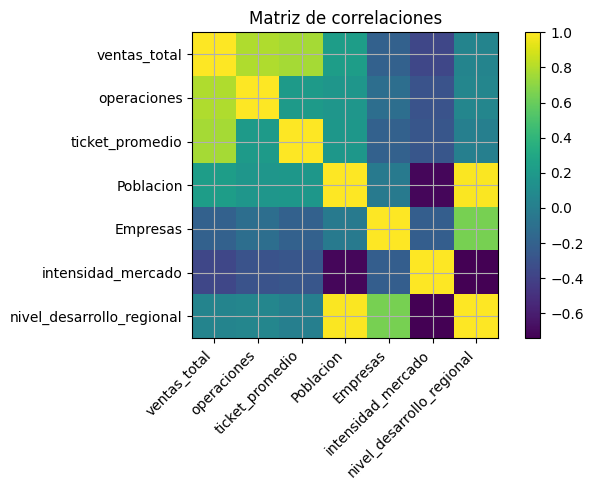

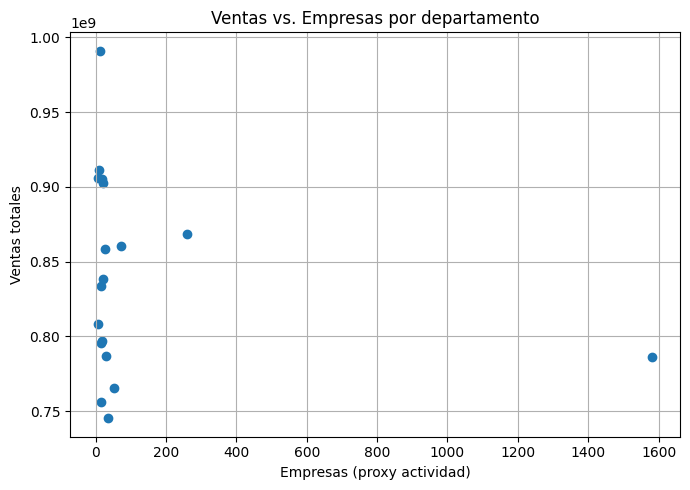

In [7]:
num_cols = ["ventas_total","operaciones","ticket_promedio","Poblacion","Empresas","intensidad_mercado","nivel_desarrollo_regional"]
corr = panel[num_cols].corr(numeric_only=True)

plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Matriz de correlaciones")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(panel["Empresas"], panel["ventas_total"])
plt.xlabel("Empresas (proxy actividad)")
plt.ylabel("Ventas totales")
plt.title("Ventas vs. Empresas por departamento")
plt.tight_layout()
plt.show()


## 8) Mapa coroplético: intensidad de mercado

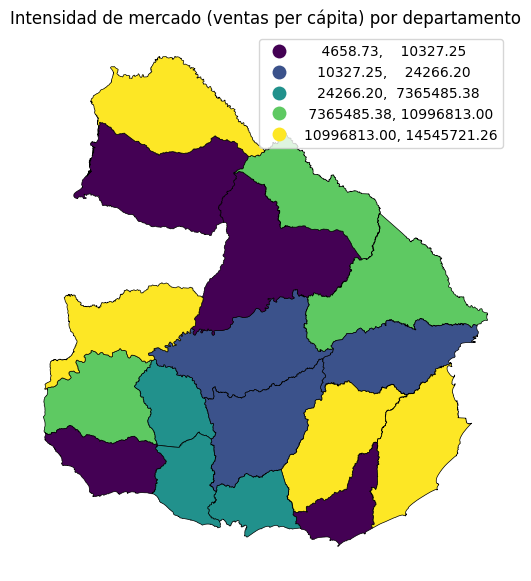

In [8]:
gdf_deptos["Departamento"] = gdf_deptos["Departamento"].str.upper()
gdf_deptos["Departamento"] = (gdf_deptos["Departamento"]
    .str.replace("RIO NEGRO","RÍO NEGRO",regex=False)
    .str.replace("PAYSANDU","PAYSANDÚ",regex=False)
    .str.replace("TACUAREMBO","TACUAREMBÓ",regex=False)
    .str.replace("SAN JOSE","SAN JOSÉ",regex=False)
)
gdf_panel = gdf_deptos.merge(panel, on="Departamento", how="left")

ax = gdf_panel.plot(column="intensidad_mercado", legend=True, figsize=(7,7),
                    scheme="Quantiles", k=5, linewidth=0.5, edgecolor="black")
ax.set_title("Intensidad de mercado (ventas per cápita) por departamento")
ax.axis("off")
plt.show()


## 9) Insights (hallazgos para Gerencia) — auto-generados

In [9]:
import numpy as np

top_int = (panel[['Departamento','intensidad_mercado']]
           .dropna()
           .sort_values('intensidad_mercado', ascending=False)
           .head(5))
corr_emp = panel[['ventas_total','Empresas']].corr(numeric_only=True).iloc[0,1]

rk_ventas = panel[['Departamento','ventas_total']].sort_values('ventas_total', ascending=False).reset_index(drop=True)
rk_ventas['rk_ventas'] = np.arange(1, len(rk_ventas)+1)
rk_desarr = panel[['Departamento','nivel_desarrollo_regional']].sort_values('nivel_desarrollo_regional', ascending=False).reset_index(drop=True)
rk_desarr['rk_desarrollo'] = np.arange(1, len(rk_desarr)+1)
ranks = rk_ventas.merge(rk_desarr, on='Departamento', how='outer')
ranks['delta_rk'] = ranks['rk_desarrollo'] - ranks['rk_ventas']
ranks = ranks.sort_values('delta_rk', ascending=False)

suben = ranks[ranks['delta_rk']>0].head(3)
bajan = ranks[ranks['delta_rk']<0].tail(3)

reco = []
if corr_emp >= 0.5:
    reco.append("Fuerte asociación Empresas~Ventas → priorizar departamentos con mayor densidad empresarial.")
elif corr_emp >= 0.2:
    reco.append("Asociación moderada → combinar cobertura comercial con generación de demanda.")
else:
    reco.append("Baja asociación → explorar factores alternativos (mix, pricing, canales, logística).")

q75_int = panel['intensidad_mercado'].quantile(0.75)
med_ventas = panel['ventas_total'].median()
oportunidad = panel[(panel['intensidad_mercado']>=q75_int) & (panel['ventas_total']<=med_ventas)]

print("INSIGHTS (para Gerencia)\n")
print("• Top 5 por **ventas per cápita**:")
for _, r in top_int.iterrows():
    print(f"  - {r['Departamento']}: intensidad_mercado={r['intensidad_mercado']:.6f}")
print(f"\n• Relación **Ventas ~ Empresas**: Pearson = {corr_emp:.3f} "
      f"({'fuerte' if abs(corr_emp)>=0.5 else 'moderada' if abs(corr_emp)>=0.2 else 'débil'})")
print("\n• Cambios de ranking por **desarrollo regional** (rk_desarrollo - rk_ventas):")
if not suben.empty:
    print("  ↑ Suben:")
    for _, r in suben.iterrows():
        print(f"   - {r['Departamento']}: Δrk={int(r['delta_rk'])}")
if not bajan.empty:
    print("  ↓ Bajan:")
    for _, r in bajan.iterrows():
        print(f"   - {r['Departamento']}: Δrk={int(r['delta_rk'])}")
print("\n• Recomendaciones:")
if not oportunidad.empty:
    reco.append("Oportunidad: alta **intensidad** pero **ventas totales** medias/bajas → asignar inventario/promos focalizadas.")
for r in reco:
    print(f"  - {r}")


INSIGHTS (para Gerencia)

• Top 5 por **ventas per cápita**:
  - RÍO NEGRO: intensidad_mercado=14545721.263581
  - LAVALLEJA: intensidad_mercado=14255879.520530
  - ROCHA: intensidad_mercado=13306444.380801
  - ARTIGAS: intensidad_mercado=11363748.136337
  - SORIANO: intensidad_mercado=9529072.438676

• Relación **Ventas ~ Empresas**: Pearson = -0.199 (débil)

• Cambios de ranking por **desarrollo regional** (rk_desarrollo - rk_ventas):
  ↑ Suben:
   - ROCHA: Δrk=15
   - ARTIGAS: Δrk=7
   - TREINTA Y TRES: Δrk=6
  ↓ Bajan:
   - SAN JOSÉ: Δrk=-7
   - MONTEVIDEO: Δrk=-14
   - MALDONADO: Δrk=-14

• Recomendaciones:
  - Baja asociación → explorar factores alternativos (mix, pricing, canales, logística).
  - Oportunidad: alta **intensidad** pero **ventas totales** medias/bajas → asignar inventario/promos focalizadas.


## 10) Exportar dataset enriquecido (para modelado / dashboard)

In [ ]:
output_csv = "ventas_enriquecidas_uy.csv"
panel.to_csv(output_csv, index=False, encoding="utf-8")
print(f"Archivo exportado: {output_csv}")


---


